# Import Libraries and Tools Preparation

In [1]:
# !pip install fcmeans
# !pip install yellowbrick
# !pip install scikit-learn-extra
# !pip install kmodes

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from plotly.graph_objs import Scatter3d
import plotly.offline as pyo
from plotly.offline import iplot

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from fcmeans import FCM
from kmodes.kprototypes import KPrototypes
from sklearn.mixture import GaussianMixture

from scipy.spatial import ConvexHull
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

## utils

In [3]:
sns.set_style({'axes.grid' : False})
pyo.init_notebook_mode()

def savefig(filename):
    plt.savefig(f'./visualization/{filename}.png', bbox_inches='tight')
    
def addBarLabels(xs, ys, texts=None, ax=None):
    if texts is None:
        texts = ys

    if ax is None:
        for x, y, text in zip(xs, ys, texts):
            plt.text(x, y, text, ha = 'center')
    else:
        for x, y, text in zip(xs, ys, texts):
            ax.text(x, y, text, ha = 'center')

def visualize2DClusterPoints(dataset, cluster_labels, total_cluster, colors, ax=None):
    for l, c in zip(range(0, total_cluster), colors):
        if ax is None:
            plt.scatter(dataset.iloc[cluster_labels[total_cluster] == l, 0],
                        dataset.iloc[cluster_labels[total_cluster] == l, 1],
                        color=c, label=f'cluster {l}',
                        alpha=0.9, marker='o', s=75)
        else:
            ax.scatter(dataset.iloc[cluster_labels[total_cluster] == l, 0],
                       dataset.iloc[cluster_labels[total_cluster] == l, 1],
                       color=c, label=f'cluster {l}',
                       alpha=0.9, marker='o', s=75)

        points = dataset.iloc[cluster_labels[total_cluster] == l, 0:2].values
        
        if points.shape[0] == 2:
            if ax is None:
                plt.plot(dataset.iloc[cluster_labels[total_cluster] == l, 0], 
                         dataset.iloc[cluster_labels[total_cluster] == l, 1],
                         color=c, linestyle='-', linewidth=2)
            else:
                ax.plot(dataset.iloc[cluster_labels[total_cluster] == l, 0], 
                        dataset.iloc[cluster_labels[total_cluster] == l, 1],
                        color=c, linestyle='-', linewidth=2)
        elif points.shape[0] > 3:
            hull = ConvexHull(points)
            
            x_hull = np.append(points[hull.vertices,0],
                               points[hull.vertices,0][0])
            y_hull = np.append(points[hull.vertices,1],
                               points[hull.vertices,1][0])
            
            if ax is None:
                plt.fill(x_hull, y_hull, alpha=0.08, c=c)
            else:
                ax.fill(x_hull, y_hull, alpha=0.08, c=c)
        
def visualize3DClusterPoints(dataset, cluster_labels, total_cluster, model_name, colors):
    traces = []

    for l, c in zip(range(0, total_cluster), colors * [255, 255, 255, 1]):
        marker = dict(
            color=f'rgba({c[0]}, {c[1]}, {c[2]}, {c[3]})',
            size=6
        )
        traces.append(Scatter3d(x=dataset.iloc[cluster_labels[total_cluster] == l, 0],
                                y=dataset.iloc[cluster_labels[total_cluster] == l, 1], 
                                z=dataset.iloc[cluster_labels[total_cluster] == l, 2], 
                                mode="markers", name=f'Cluster {l}', 
                                marker=marker
                               ))

    layout = dict(title=f"Visualizing {model_name} Clusters in Three Dimensions Using The First 3 Component",
                  scene=dict(
                      xaxis_title='PC 0',
                      yaxis_title='PC 1',
                      zaxis_title='PC 2'
                  ))
    fig = dict(data=traces, layout=layout)

    iplot(fig)

# Load Dataset

In [4]:
path_dataset_initial = './data/dataset_train_preprocess_only.csv'
path_dataset_outlier_treatment = './data/dataset_train_preprocess_and_outlier_treatment.csv'
path_dataset_pca_outlier_treated = './data/dataset_train_pca_outlier_treated.csv'

# path_dataset_tsvd = './data/dataset_train_tsvd.csv'
# path_dataset_famd = './data/dataset_train_famd.csv'
# path_dataset_tsne = './data/dataset_train_tsne.csv'

df_preprocess = pd.read_csv(path_dataset_initial)
df_outlier_treatment = pd.read_csv(path_dataset_outlier_treatment)
df_outlier_pca = pd.read_csv(path_dataset_pca_outlier_treated)

## Preproccessing + Outlier Treatment

In [5]:
df_outlier_treatment.head()

tahun_lahir       ipk  ips_semester_genap_2021/2022   
0    -1.524608 -0.811601                     -1.288372  \
1    -1.524608 -0.224720                     -0.670409   
2    -0.173425 -0.118692                     -0.262257   
3    -0.173425 -0.010230                      0.491118   
4    -0.173425 -0.037575                     -0.012235   

   ips_semester_ganjil_2022/2023  nilai_matkul_matematika_1   
0                      -0.684552                  -0.241454  \
1                      -0.108950                  -0.241454   
2                      -0.736376                   1.067380   
3                       0.338446                  -0.241454   
4                      -0.021934                  -1.153925   

   nilai_matkul_bahasa_inggris_1  total_sks_semester  total_matkul_mengulang   
0                       0.373689            0.216663                1.956294  \
1                      -0.982475            0.216663               -0.502139   
2                       0.373689            0.216663               -0.502139   
3                       1.217077            0.216663                1.956294   
4                      -1.494403            0.216663               -0.502139   

   memiliki_beasiswa  nilai_matematika_sma_kelas_12  ...   
0          -0.397911                      -1.783712  ...  \
1          -0.397911                       0.168587  ...   
2          -0.397911                       0.168587  ...   
3          -0.397911                      -1.248480  ...   
4          -0.397911                       0.168587  ...   

   jenis_tempat_tinggal_keluarga_bersama anggota keluarga besar   
0                                                0.0             \
1                                                1.0              
2                                                0.0              
3                                                0.0              
4                                                0.0              

   jenis_tempat_tinggal_keluarga_kontrakan   
0                                      0.0  \
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   jenis_tempat_tinggal_keluarga_rumah   
0                                  1.0  \
1                                  0.0   
2                                  1.0   
3                                  1.0   
4                                  1.0   

   jenis_tempat_tinggal_keluarga_rumah dinas  cara_belajar_mahasiswa_aural   
0                                        0.0                           0.0  \
1                                        0.0                           0.0   
2                                        0.0                           0.0   
3                                        0.0                           1.0   
4                                        0.0                           0.0   

   cara_belajar_mahasiswa_kinestetic  cara_belajar_mahasiswa_reading   
0                                0.0                             0.0  \
1                                0.0                             0.0   
2                                0.0                             0.0   
3                                0.0                             0.0   
4                                0.0                             1.0   

   cara_belajar_mahasiswa_visual  akses_pembelajaran_daring   
0                            1.0                        1.0  \
1                            1.0                        0.0   
2                            1.0                        1.0   
3                            0.0                        0.0   
4                            0.0                        0.0   

   akses_pembelajaran_luring  
0                        0.0  
1                        1.0  
2                        0.0  
3                        1.0  
4                        1.0  

[5 rows x 98 columns]

In [6]:
df_outlier_treatment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 98 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   tahun_lahir                                                   139 non-null    float64
 1   ipk                                                           139 non-null    float64
 2   ips_semester_genap_2021/2022                                  139 non-null    float64
 3   ips_semester_ganjil_2022/2023                                 139 non-null    float64
 4   nilai_matkul_matematika_1                                     139 non-null    float64
 5   nilai_matkul_bahasa_inggris_1                                 139 non-null    float64
 6   total_sks_semester                                            139 non-null    float64
 7   total_matkul_mengulang                                        139 non-n

In [7]:
df_outlier_treatment.describe().T

count          mean       std       min   
tahun_lahir                        139.0 -3.194886e-16  1.003617 -1.524608  \
ipk                                139.0  2.428114e-16  1.003617 -2.100581   
ips_semester_genap_2021/2022       139.0  2.811500e-16  1.003617 -1.806816   
ips_semester_ganjil_2022/2023      139.0  6.261977e-16  1.003617 -2.003897   
nilai_matkul_matematika_1          139.0 -1.277955e-16  1.003617 -1.633825   
...                                  ...           ...       ...       ...   
cara_belajar_mahasiswa_kinestetic  139.0  1.079137e-01  0.311393  0.000000   
cara_belajar_mahasiswa_reading     139.0  2.374101e-01  0.427034  0.000000   
cara_belajar_mahasiswa_visual      139.0  4.100719e-01  0.493625  0.000000   
akses_pembelajaran_daring          139.0  3.021583e-01  0.460854  0.000000   
akses_pembelajaran_luring          139.0  6.978417e-01  0.460854  0.000000   

                                        25%       50%       75%       max  
tahun_lahir                       -0.173425 -0.173425  1.073615  2.243486  
ipk                               -0.637048 -0.037575  0.803964  2.083084  
ips_semester_genap_2021/2022      -0.514402 -0.012235  0.633335  2.116571  
ips_semester_ganjil_2022/2023     -0.552677 -0.021934  0.702694  2.217036  
nilai_matkul_matematika_1         -1.153925  0.200890  1.067380  1.067380  
...                                     ...       ...       ...       ...  
cara_belajar_mahasiswa_kinestetic  0.000000  0.000000  0.000000  1.000000  
cara_belajar_mahasiswa_reading     0.000000  0.000000  0.000000  1.000000  
cara_belajar_mahasiswa_visual      0.000000  0.000000  1.000000  1.000000  
akses_pembelajaran_daring          0.000000  0.000000  1.000000  1.000000  
akses_pembelajaran_luring          0.000000  1.000000  1.000000  1.000000  

[98 rows x 8 columns]

## Preproccessing + Outlier Treatment + Dimensional Reduction

In [8]:
df_outlier_pca.head()

nilai_ipk_ips_sks_semester_minat_lomba_tinggi  perjalanan_kampus_lama   
0                                       1.802894               -0.987998  \
1                                       1.034113                0.574502   
2                                       0.953768               -1.669826   
3                                       0.875784               -1.678915   
4                                       0.824546               -0.177371   

   pendidikan_ortu_rendah  nilai_matkul_bahasa_inggris_matematika_rendah   
0                2.643094                                       1.842919  \
1               -0.074227                                      -1.108725   
2               -1.153220                                       1.402366   
3               -2.111825                                       1.653553   
4               -0.355137                                      -1.983383   

   sering_akses_sosial_media_sedikit_waktu_belajar   
0                                        -0.972748  \
1                                        -0.518584   
2                                         0.361635   
3                                        -0.395017   
4                                        -0.541855   

   penghasilan_ortu_rendah_memiliki_beasiswa  jumlah_saudara_banyak   
0                                  -1.090438              -2.375681  \
1                                  -1.794490               1.070784   
2                                   0.039076               1.788102   
3                                   0.362637              -1.096472   
4                                  -1.467023               0.232592   

   total_matkul_mengulang_banyak  meluangkan_waktu_belajar   
0                       0.378085                 -0.139148  \
1                      -0.468657                  0.366720   
2                      -0.501662                 -0.251744   
3                      -1.738698                  0.151666   
4                      -0.454347                 -0.629288   

   matkul_semester_1_matematika_tinggi_binggris_rendah   
0                                           0.056194    \
1                                          -0.802308     
2                                          -0.468878     
3                                          -0.818600     
4                                           0.336627     

   sedikit_bermain_game_pendidikan_ayah_tinggi   
0                                    -0.446964  \
1                                    -0.880928   
2                                    -1.048272   
3                                     0.283170   
4                                     0.004721   

   preferensi_belajar_luring_genre_permainan_teka-teki_petualangan   
0                                          -0.639467                \
1                                           0.616052                 
2                                           0.929218                 
3                                          -1.382514                 
4                                           0.602788                 

   penghasilan_orang_tua_tinggi  latar_belakang_sma_swasta   
0                      0.027574                  -0.069716  \
1                      0.543570                   0.280447   
2                      0.286884                   0.796428   
3                     -0.159871                   0.247079   
4                     -0.634478                  -0.046715   

   latar_belakang_sma_negeri  pendidikan_ibu_tinggi   
0                   0.006755               0.379956  \
1                  -0.516950               1.106705   
2                  -0.301361               0.911326   
3                  -0.995713               0.645939   
4                  -1.300004              -1.033594   

   jalur_pendaftaran_kampus_seleksi_rapot_organuisasi_himpunan_mahasiswa   
0                                           0.303871                      \
1                                    

In [9]:
df_outlier_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 19 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   nilai_ipk_ips_sks_semester_minat_lomba_tinggi                          139 non-null    float64
 1   perjalanan_kampus_lama                                                 139 non-null    float64
 2   pendidikan_ortu_rendah                                                 139 non-null    float64
 3   nilai_matkul_bahasa_inggris_matematika_rendah                          139 non-null    float64
 4   sering_akses_sosial_media_sedikit_waktu_belajar                        139 non-null    float64
 5   penghasilan_ortu_rendah_memiliki_beasiswa                              139 non-null    float64
 6   jumlah_saudara_banyak                                                  139 non-null    flo

In [10]:
df_outlier_pca.describe().T

count          mean   
nilai_ipk_ips_sks_semester_minat_lomba_tinggi       139.0  5.111818e-16  \
perjalanan_kampus_lama                              139.0  3.961659e-16   
pendidikan_ortu_rendah                              139.0  1.725239e-16   
nilai_matkul_bahasa_inggris_matematika_rendah       139.0  1.150159e-16   
sering_akses_sosial_media_sedikit_waktu_belajar     139.0 -5.878591e-16   
penghasilan_ortu_rendah_memiliki_beasiswa           139.0 -4.089455e-16   
jumlah_saudara_banyak                               139.0  2.172523e-16   
total_matkul_mengulang_banyak                       139.0 -5.111818e-17   
meluangkan_waktu_belajar                            139.0 -8.306705e-17   
matkul_semester_1_matematika_tinggi_binggris_re...  139.0  2.204472e-16   
sedikit_bermain_game_pendidikan_ayah_tinggi         139.0  5.111818e-16   
preferensi_belajar_luring_genre_permainan_teka-...  139.0 -2.939295e-16   
penghasilan_orang_tua_tinggi                        139.0 -2.555909e-17   
latar_belakang_sma_swasta                           139.0  2.492011e-16   
latar_belakang_sma_negeri                           139.0 -5.111818e-17   
pendidikan_ibu_tinggi                               139.0 -5.111818e-17   
jalur_pendaftaran_kampus_seleksi_rapot_organuis...  139.0  2.683705e-16   
sosial_media_twitter_tiktok_gaya_belajar_visual     139.0  2.555909e-16   
gaya_belajar_aural_preferensi_belajar_daring        139.0  4.472841e-17   

                                                         std       min   
nilai_ipk_ips_sks_semester_minat_lomba_tinggi       2.124948 -4.761316  \
perjalanan_kampus_lama                              1.425123 -3.130467   
pendidikan_ortu_rendah                              1.330878 -3.571047   
nilai_matkul_bahasa_inggris_matematika_rendah       1.232742 -3.069154   
sering_akses_sosial_media_sedikit_waktu_belajar     1.200553 -2.186775   
penghasilan_ortu_rendah_memiliki_beasiswa           1.148285 -2.850402   
jumlah_saudara_banyak                               1.043916 -2.904791   
total_matkul_mengulang_banyak                       0.983092 -2.034658   
meluangkan_waktu_belajar                            0.944111 -2.460498   
matkul_semester_1_matematika_tinggi_binggris_re...  0.930912 -1.934913   
sedikit_bermain_game_pendidikan_ayah_tinggi         0.897553 -2.103323   
preferensi_belajar_luring_genre_permainan_teka-...  0.844593 -2.119731   
penghasilan_orang_tua_tinggi                        0.812233 -2.096083   
latar_belakang_sma_swasta                           0.794811 -1.943976   
latar_belakang_sma_negeri                           0.769151 -1.877784   
pendidikan_ibu_tinggi                               0.732018 -1.784611   
jalur_pendaftaran_kampus_seleksi_rapot_organuis...  0.710968 -1.737711   
sosial_media_twitter_tiktok_gaya_belajar_visual     0.671580 -1.492949   
gaya_belajar_aural_preferensi_belajar_daring        0.650304 -1.342145   

                                                         25%       50%   
nilai_ipk_ips_sks_semester_minat_lomba_tinggi      -1.527225 -0.173593  \
perjalanan_kampus_lama                             -1.046419 -0.281010   
pendidikan_ortu_rendah                             -0.949236  0.078129   
nilai_matkul_bahasa_inggris_matematika_rendah      -0.905413  0.040872   
sering_akses_sosial_media_sedikit_waktu_belajar    -0.865043 -0.260948   
penghasilan_ortu_rendah_memiliki_beasiswa          -0.683950  0.009178   
jumlah_saudara_banyak                              -0.662849  0.004025   
total_matkul_mengulang_banyak                      -0.778865 -0.115116   
meluangkan_waktu_belajar                           -0.590094 -0.082458   
matkul_semester_1_matematika_tinggi_binggris_re... -0.736274 -0.013004   
sedikit_bermain_game_pendidikan_ayah_tinggi        -0.668638  0.038857   
preferensi_belajar_luring_genre_permainan_teka-... -0.613344  0.018358   
penghasilan_orang_tua_tinggi                       -0.591347  0.027574   
latar_belakang_sma_swasta         

# Create Clustering Model


references: <br>
https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/ <br>
https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1 <br>
https://stackabuse.com/k-means-elbow-method-and-silhouette-analysis-with-yellowbrick-and-scikit-learn/ <br>

In [11]:
dataset_model = df_outlier_pca
dataset_model_normal = df_outlier_treatment

## Determine Total Cluster using Elbow Plot and Silhouette Analysis

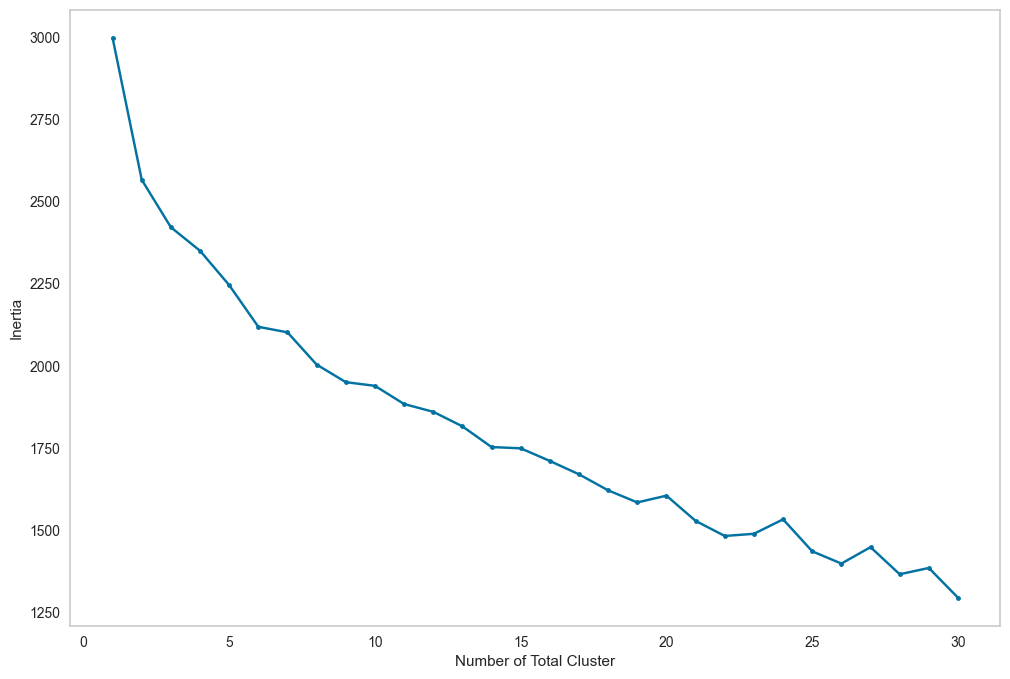

In [12]:
inertia_values = []
max_cluster = 30

for cluster in range(max_cluster):
#     print(cluster)
#     kmeans = KMeans(n_clusters=cluster+1, n_init='auto')
    kmeans = KMeans(n_clusters=cluster+1, init='k-means++', n_init=1)
    kmeans.fit(dataset_model)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=[12, 8])

plt.plot(np.arange(1, max_cluster+1, step=1), inertia_values, marker='.', linestyle='-')

plt.xlabel('Number of Total Cluster')
plt.ylabel('Inertia')

savefig('elbow_plot_visualization')
plt.show()

In [13]:
# k_elbow_distribution = []
# k_elbow_sample_count = 200

# for i in tqdm(range(k_elbow_sample_count)):    
#     elb_visualizer = KElbowVisualizer(KMeans(init='k-means++', n_init=1), k=(1, max_cluster))
#     elb_visualizer.fit(dataset_model)
#     k_elbow_distribution.append(elb_visualizer.elbow_value_)
# k_elbow_distribution = np.array(k_elbow_distribution)
    
# plt.close()

In [14]:
# kelbow_visualizer(KMeans(init='k-means++', n_init=1), dataset_model, k=(1, max_cluster))
# plt.show()

In [15]:
# ### To Avoid yellowbirck reconfigure or reformatting plot
# ### source: https://stackoverflow.com/questions/67009111/kelbowvisualizer-re-formatting-other-plots

# del KElbowVisualizer
# del kelbow_visualizer

In [16]:
# temp = sns.histplot(x=k_elbow_distribution,
#                     stat='count', discrete=True, shrink=0.9)
# temp.set_xticks(np.unique(k_elbow_distribution))

# plt.show()

# k_elbow, count = np.unique(k_elbow_distribution, return_counts=True)
# for k_elbow, count in zip(k_elbow, count):
#     print(f'K Elbow: {k_elbow} | Frequency: {count}')

In [17]:
n_clusters = [4, 5, 6, 7]

## K-Means Clustering

### Create Model

In [18]:
kmeans_models = {}

for total_cluster in n_clusters:
    model = KMeans(n_clusters=total_cluster, n_init='auto')
    model.fit(dataset_model)
    kmeans_models[total_cluster] = model

In [19]:
kmeans_labels = {}

for total_cluster in n_clusters:
    kmeans_labels[total_cluster] = kmeans_models[total_cluster].labels_

## Fuzzy C-Means Clustering

### Create Model

In [20]:
fcm_models = {}

for total_cluster in n_clusters:
    model = FCM(n_clusters=total_cluster)
    model.fit(dataset_model.to_numpy())
    fcm_models[total_cluster] = model

In [21]:
fcm_soft_label = {}

for total_cluster in n_clusters:
    fcm_soft_label[total_cluster] = fcm_models[total_cluster].soft_predict(dataset_model.to_numpy())

In [22]:
fcm_highest_label = {}

for total_cluster in n_clusters:
    fcm_highest_label[total_cluster] = fcm_models[total_cluster].predict(dataset_model.to_numpy())

## K-Medoids Clustering

### Create Model

In [23]:
kmedoids_models = {}

for total_cluster in n_clusters:
    model = KMedoids(n_clusters=total_cluster)
    model.fit(dataset_model)
    kmedoids_models[total_cluster] = model

In [24]:
kmedoids_labels = {}

for total_cluster in n_clusters:
    kmedoids_labels[total_cluster] = kmedoids_models[total_cluster].labels_

## K-Prototype without Dimensional Reduction

### Get List of Categorical Columns

In [25]:
sparse_list = ['jenis_kelamin', 'tempat_tinggal_kuliah', 'provinsi_asal', 'jalur_pendaftaran_kampus', 'tipe_sma', 'latar_belakang_sma', 'jenis_tempat_tinggal_keluarga', 'cara_belajar_mahasiswa', 'akses_pembelajaran', 'sosial_media', 'genre_permainan', 'jenis_organisasi']
sparse_column = []

for column in sparse_list:
    sparse_column.extend([dataset_model_normal.columns.get_loc(col) for col in df_outlier_treatment if col.startswith(column)])

print(len(sparse_column))
display(list(df_outlier_treatment.iloc[:, sparse_column].columns))

79


['jenis_kelamin_laki-laki',
 'jenis_kelamin_perempuan',
 'tempat_tinggal_kuliah_apartemen',
 'tempat_tinggal_kuliah_asrama',
 'tempat_tinggal_kuliah_bersama anggota keluarga besar',
 'tempat_tinggal_kuliah_bersama orang tua',
 'tempat_tinggal_kuliah_kontrakan',
 'tempat_tinggal_kuliah_kos',
 'provinsi_asal_bali',
 'provinsi_asal_bangka belitung',
 'provinsi_asal_banten',
 'provinsi_asal_bengkulu',
 'provinsi_asal_dki jakarta',
 'provinsi_asal_jambi',
 'provinsi_asal_jawa barat',
 'provinsi_asal_jawa tengah',
 'provinsi_asal_jawa timur',
 'provinsi_asal_kalimantan timur',
 'provinsi_asal_maluku utara',
 'provinsi_asal_nanggroe aceh darussalam',
 'provinsi_asal_nusa tenggara barat',
 'provinsi_asal_nusa tenggara timur',
 'provinsi_asal_papua barat',
 'provinsi_asal_papua barat daya',
 'provinsi_asal_riau',
 'provinsi_asal_sulawesi selatan',
 'provinsi_asal_sulawesi tengah',
 'provinsi_asal_sulawesi tenggara',
 'provinsi_asal_sulawesi utara',
 'provinsi_asal_sumatera barat',
 'provinsi_as

### Create Model

In [26]:
kprototype_models = {}

for total_cluster in n_clusters:
    model = KPrototypes(n_clusters=total_cluster, init='Cao')
    model.fit(dataset_model_normal, categorical=sparse_column)
    kprototype_models[total_cluster] = model

In [27]:
kprototype_labels = {}

for total_cluster in n_clusters:
    kprototype_labels[total_cluster] = kprototype_models[total_cluster].labels_

## Gaussian Mixture Model Clustering

In [28]:
gmm_models = {}

for total_cluster in n_clusters:
    model = GaussianMixture(n_components=total_cluster)
    model.fit(dataset_model)
    gmm_models[total_cluster] = model

In [29]:
gmm_soft_label = {}

for total_cluster in n_clusters:
    gmm_soft_label[total_cluster] = gmm_models[total_cluster].predict_proba(dataset_model)

In [30]:
gmm_labels = {}

for total_cluster in n_clusters:
    gmm_labels[total_cluster] = gmm_models[total_cluster].predict(dataset_model)

# Clustering Evaluation

## Davien-Bouldin Index

In [31]:
for total_cluster in n_clusters:
    print(f'DBI Score using total cluster of {total_cluster}:\n')
    
    kmeans_dbi = davies_bouldin_score(dataset_model, kmeans_labels[total_cluster])
    print(f'K-Means Clustering = {np.round(kmeans_dbi, 3)}')
    
    fcm_dbi = davies_bouldin_score(dataset_model, fcm_highest_label[total_cluster])
    print(f'Fuzzy C-Means Clustering = {np.round(fcm_dbi, 3)}')
    
    kmedoids_dbi = davies_bouldin_score(dataset_model, kmedoids_labels[total_cluster])
    print(f'K-Medoids Clustering = {np.round(kmedoids_dbi, 3)}')
    
    kprototype_dbi = davies_bouldin_score(df_outlier_treatment, kprototype_labels[total_cluster])
    print(f'K-Prototype Clustering = {np.round(kprototype_dbi, 3)}')
        
#     gmm_dbi = davies_bouldin_score(dataset_model, gmm_labels[total_cluster])
#     print(f'GMM Clustering = {np.round(gmm_dbi, 3)}')
    
    print('='*30)

DBI Score using total cluster of 4:

K-Means Clustering = 3.203
Fuzzy C-Means Clustering = 2.408
K-Medoids Clustering = 3.617
K-Prototype Clustering = 2.99
DBI Score using total cluster of 5:

K-Means Clustering = 2.68
Fuzzy C-Means Clustering = 2.408
K-Medoids Clustering = 3.425
K-Prototype Clustering = 3.062
DBI Score using total cluster of 6:

K-Means Clustering = 2.503
Fuzzy C-Means Clustering = 2.408
K-Medoids Clustering = 3.45
K-Prototype Clustering = 2.901
DBI Score using total cluster of 7:

K-Means Clustering = 2.452
Fuzzy C-Means Clustering = 2.408
K-Medoids Clustering = 3.319
K-Prototype Clustering = 2.929


## Labels Distribution

In [32]:
n_clusters_selected = 5
cluster_colors = plt.cm.tab10(np.linspace(0, 1, n_clusters_selected))

### K-Means

In [33]:
kmeans_labels[n_clusters_selected]

array([0, 3, 3, 3, 3, 3, 1, 2, 4, 0, 2, 3, 0, 2, 2, 1, 4, 3, 1, 2, 3, 2,
       4, 4, 0, 2, 4, 2, 0, 2, 2, 4, 4, 0, 1, 4, 3, 2, 4, 1, 4, 1, 1, 2,
       2, 2, 4, 3, 0, 3, 4, 2, 4, 3, 2, 1, 4, 2, 2, 3, 0, 4, 2, 3, 2, 2,
       1, 2, 1, 3, 3, 3, 0, 3, 1, 2, 3, 2, 4, 1, 1, 2, 3, 3, 2, 4, 4, 4,
       2, 1, 1, 4, 1, 0, 2, 2, 4, 0, 3, 2, 0, 3, 2, 2, 0, 0, 3, 2, 3, 2,
       1, 3, 0, 3, 0, 3, 3, 3, 2, 0, 3, 0, 3, 0, 3, 2, 3, 3, 3, 0, 0, 4,
       0, 3, 1, 3, 3, 0, 4])

### Fuzzy C-Means

In [34]:
fcm_soft_label[n_clusters_selected]

array([[0.20000076, 0.20000065, 0.19999951, 0.20000013, 0.19999896],
       [0.20000111, 0.20000095, 0.19999928, 0.20000019, 0.19999847],
       [0.20000075, 0.20000064, 0.19999952, 0.20000013, 0.19999898],
       [0.20000048, 0.20000041, 0.19999969, 0.20000008, 0.19999934],
       [0.20000066, 0.20000057, 0.19999957, 0.20000011, 0.19999909],
       [0.20000105, 0.2000009 , 0.19999932, 0.20000018, 0.19999855],
       [0.19999865, 0.19999885, 0.20000088, 0.19999977, 0.20000186],
       [0.19999969, 0.19999974, 0.2000002 , 0.19999995, 0.20000043],
       [0.19999928, 0.19999939, 0.20000046, 0.19999988, 0.20000098],
       [0.20000031, 0.20000026, 0.1999998 , 0.20000005, 0.19999958],
       [0.20000022, 0.20000019, 0.19999986, 0.20000004, 0.1999997 ],
       [0.20000084, 0.20000072, 0.19999945, 0.20000014, 0.19999884],
       [0.20000103, 0.20000088, 0.19999933, 0.20000017, 0.19999859],
       [0.19999901, 0.19999915, 0.20000064, 0.19999983, 0.20000137],
       [0.19999877, 0.19999895, 0.

In [35]:
# fcm_fuzzy_distribution_sample = []
# for i in np.unique(fcm_highest_label[n_clusters_selected]):
#     tmp = np.random.choice((fcm_highest_label[n_clusters_selected] == i).nonzero()[0])
#     fcm_fuzzy_distribution_sample.append(fcm_soft_label[n_clusters_selected][tmp])
    
tmp = np.random.choice(fcm_soft_label[n_clusters_selected].shape[0], 5)
fcm_fuzzy_distribution_sample = fcm_soft_label[n_clusters_selected][tmp]

fcm_fuzzy_distribution_sample = np.array(fcm_fuzzy_distribution_sample)

In [36]:
dict_fcm_fuzzy_sample = {}
for i in range(fcm_fuzzy_distribution_sample.shape[1]):
    dict_fcm_fuzzy_sample[f'Cluster {i}'] = fcm_fuzzy_distribution_sample[:, i]

# df_fcm_fuzzy_sample = pd.DataFrame(dict_fcm_fuzzy_sample, index=[i for i in np.unique(fcm_highest_label[n_clusters_selected])])
df_fcm_fuzzy_sample = pd.DataFrame(dict_fcm_fuzzy_sample, index=[f'Sample {i+1}' for i in range(fcm_fuzzy_distribution_sample.shape[0])])

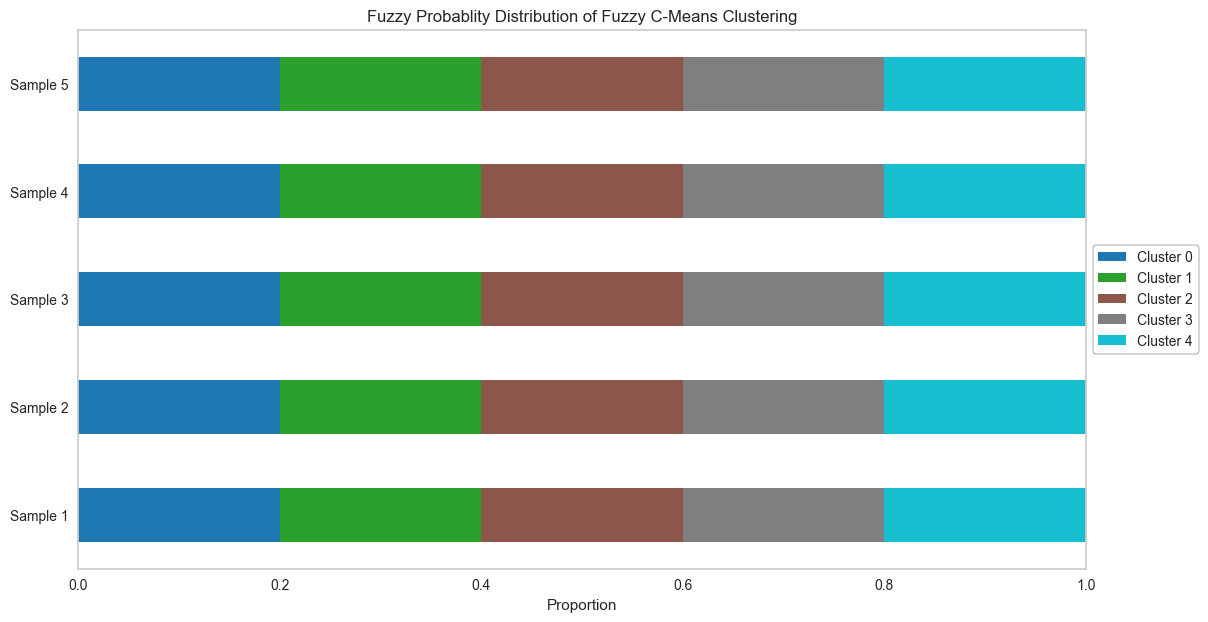

In [37]:
colormap = ['blue' if x == 3 else 'lightgrey' for x in range(n_clusters_selected)]
fig, ax = plt.subplots(figsize=[13, 7])

df_fcm_fuzzy_sample.plot(kind='barh', stacked=True, colormap='tab10', ax=ax)
# df_fcm_fuzzy_sample.plot(kind='barh', stacked=True,
#                          color=colormap, edgecolor='black', ax=ax)

legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)
legend.get_frame().set_edgecolor('black')

ax.set_xlim(0, 1)
ax.set_xlabel('Proportion')
ax.set_title('Fuzzy Probablity Distribution of Fuzzy C-Means Clustering')

savefig('Fuzzy Probablity Distribution of Fuzzy C-Means Clustering')
plt.show()

In [38]:
fcm_highest_label[n_clusters_selected]

array([0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 0, 4, 4, 4, 4, 0, 4, 4, 0, 4,
       4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 0, 4, 4, 4, 0, 4, 4, 0,
       0, 4, 0, 0, 4, 0, 4, 4, 4, 0, 0, 4, 4, 4, 4, 0, 0, 4, 4, 0, 4, 4,
       4, 4, 4, 0, 0, 0, 4, 0, 4, 4, 0, 4, 4, 4, 4, 4, 0, 0, 4, 0, 4, 4,
       4, 4, 4, 0, 4, 0, 4, 4, 4, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 4,
       4, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       0, 0, 0, 0, 0, 0, 4], dtype=int64)

### K-Medoids

In [39]:
kmedoids_labels[n_clusters_selected]

array([1, 1, 1, 0, 0, 0, 3, 1, 2, 1, 4, 4, 3, 1, 3, 3, 0, 1, 3, 3, 1, 1,
       0, 4, 3, 3, 0, 3, 3, 3, 3, 4, 4, 2, 0, 2, 4, 1, 4, 3, 4, 0, 3, 4,
       4, 3, 0, 0, 3, 4, 4, 1, 4, 0, 1, 0, 2, 1, 1, 0, 1, 2, 4, 0, 3, 2,
       2, 1, 3, 0, 0, 0, 3, 1, 3, 3, 2, 2, 4, 3, 3, 1, 0, 2, 1, 0, 2, 2,
       3, 2, 3, 0, 3, 2, 2, 1, 2, 0, 1, 1, 3, 0, 1, 0, 3, 0, 0, 1, 2, 1,
       3, 0, 0, 1, 0, 0, 1, 1, 3, 1, 0, 0, 1, 4, 0, 1, 4, 4, 0, 1, 0, 4,
       3, 4, 0, 4, 4, 4, 1], dtype=int64)

### K-Prototype

In [40]:
kprototype_labels[n_clusters_selected]

array([4, 1, 1, 2, 1, 4, 2, 1, 2, 1, 1, 0, 4, 1, 2, 3, 2, 1, 2, 2, 1, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 4, 3, 0, 0, 1, 0, 3, 0, 3, 2, 1,
       1, 2, 0, 4, 3, 0, 0, 2, 0, 4, 1, 3, 2, 2, 1, 1, 1, 1, 2, 4, 1, 2,
       3, 2, 3, 4, 4, 1, 2, 4, 3, 2, 4, 1, 0, 3, 3, 1, 1, 4, 2, 1, 1, 2,
       1, 3, 3, 1, 2, 1, 2, 2, 3, 1, 4, 1, 4, 4, 1, 1, 3, 0, 4, 2, 0, 2,
       3, 4, 1, 4, 1, 4, 4, 4, 2, 4, 4, 4, 4, 0, 4, 1, 1, 0, 4, 1, 3, 0,
       4, 0, 1, 4, 4, 0, 0], dtype=uint16)

### Gaussian Mixture Model

In [41]:
# gmm_soft_label[n_clusters_selected][list((gmm_labels[n_clusters_selected] == 4).nonzero()[0])]

In [42]:
gmm_labels[n_clusters_selected]

array([1, 4, 4, 3, 4, 1, 0, 3, 3, 4, 4, 1, 1, 2, 0, 0, 3, 1, 0, 0, 4, 4,
       3, 3, 2, 0, 3, 0, 3, 0, 0, 3, 2, 1, 0, 3, 1, 2, 3, 0, 3, 0, 0, 4,
       4, 2, 2, 1, 2, 1, 2, 2, 2, 1, 4, 0, 3, 4, 4, 4, 4, 3, 3, 1, 4, 3,
       0, 0, 2, 1, 1, 4, 3, 1, 0, 4, 1, 4, 3, 0, 0, 2, 3, 1, 4, 3, 3, 3,
       2, 0, 3, 2, 0, 4, 4, 2, 3, 1, 1, 4, 2, 1, 4, 2, 2, 1, 1, 0, 1, 0,
       0, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 4, 4, 1, 1, 2, 2, 2,
       2, 1, 1, 1, 1, 4, 3], dtype=int64)

### Overall

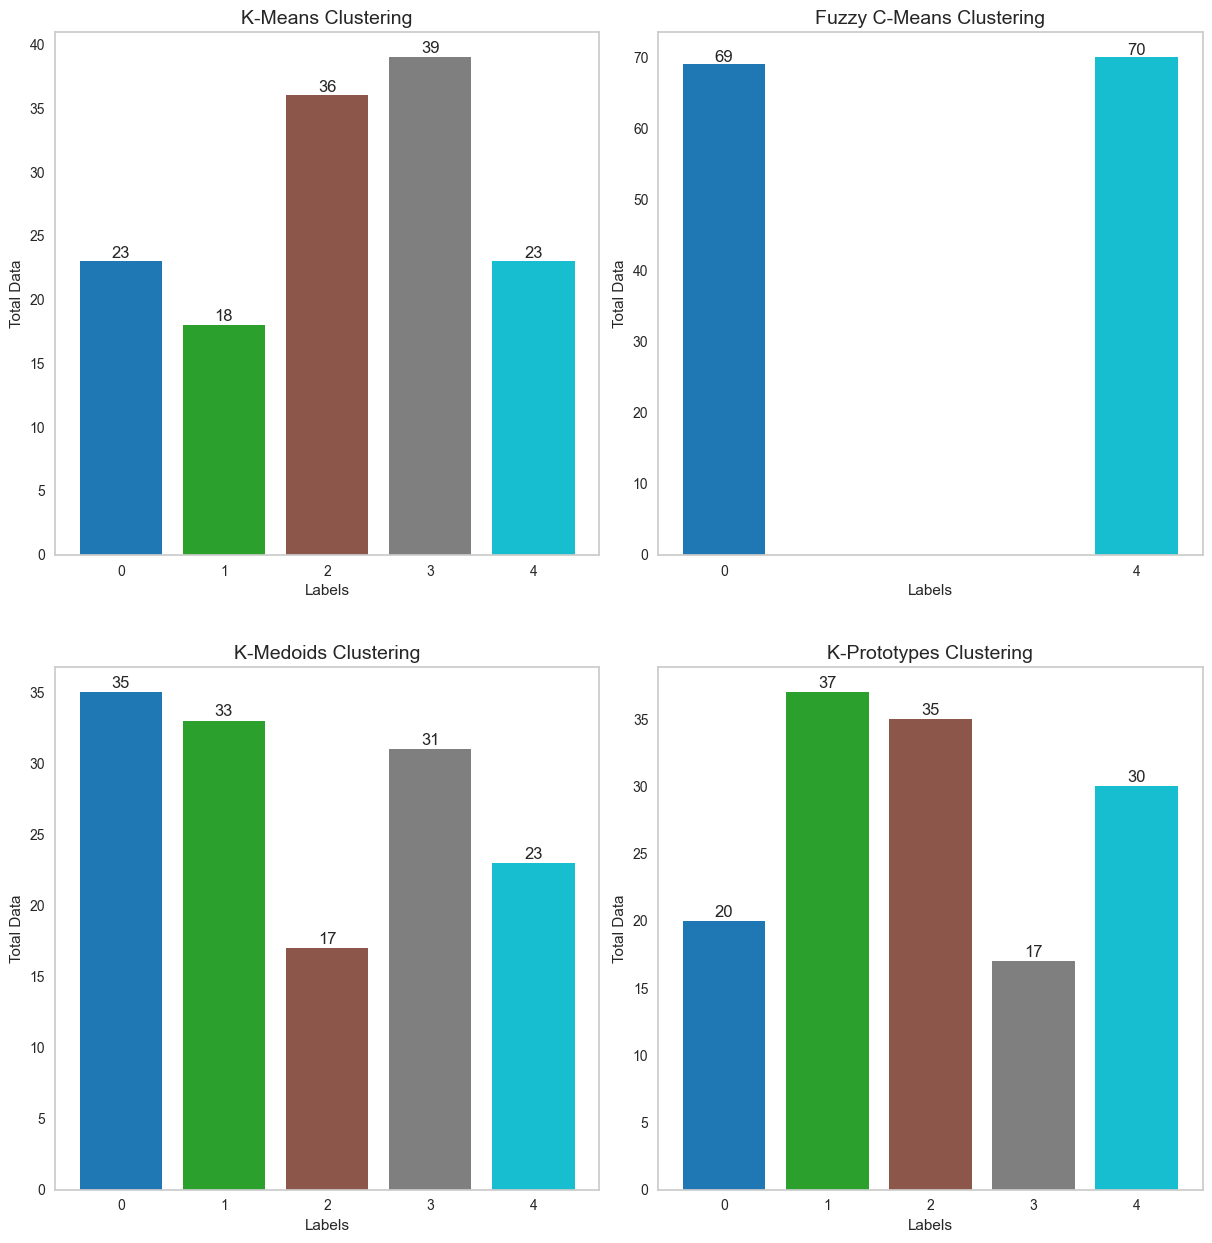

In [43]:
item = zip([kmeans_labels, fcm_highest_label, kmedoids_labels, kprototype_labels], 
           ['K-Means', 'Fuzzy C-Means', 'K-Medoids', 'K-Prototypes'])

fig, axs = plt.subplots(2, 2, figsize=[12, 12])
plt.tight_layout(pad=0.4, w_pad=1.2, h_pad=5.0)

for (label, name), ax in zip(item, axs.flatten()):    
    labels_value_counts = np.array(np.unique(label[n_clusters_selected], return_counts=True))
    
    for idx, count in enumerate(labels_value_counts[1]):
        ax.bar(labels_value_counts[0][idx], count, color=cluster_colors[labels_value_counts[0][idx]])
    
    addBarLabels(labels_value_counts[0], labels_value_counts[1] + 0.3, labels_value_counts[1], ax=ax)
    ax.set_title(f'{name} Clustering', fontsize=14)
    ax.set_xlabel('Labels')
    ax.set_ylabel('Total Data')
    ax.set_xticks(np.unique(labels_value_counts[0]))

savefig('model_clusters_distribution')
plt.show()

# Cluster Visualization

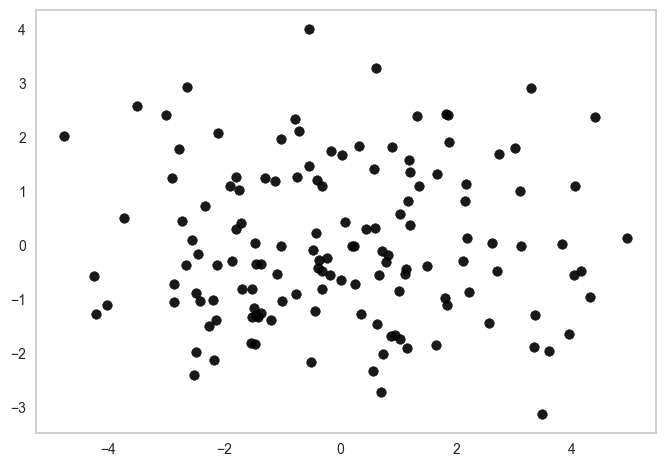

In [44]:
plt.scatter(dataset_model.iloc[:, 0],
            dataset_model.iloc[:, 1],
            color='black',
            alpha=0.9,
            marker='o'
            )

## K-Means

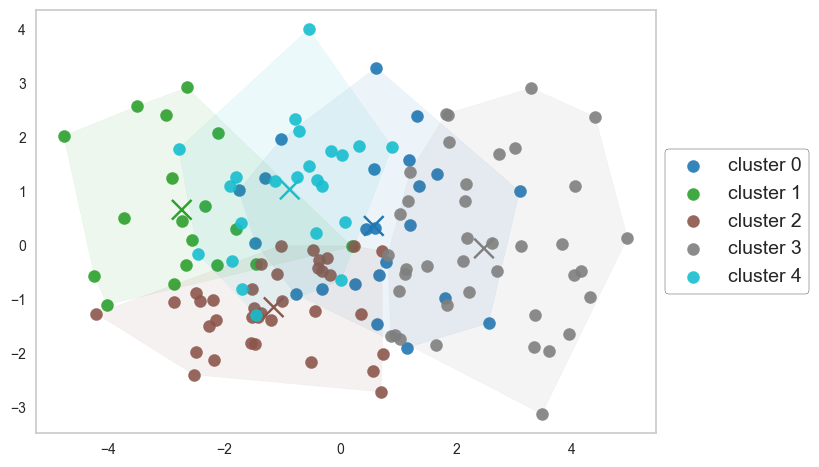

In [45]:
visualize2DClusterPoints(dataset_model, kmeans_labels, n_clusters_selected, cluster_colors)

centroids = kmeans_models[n_clusters_selected].cluster_centers_
centroids_x = centroids[:, 0]
centroids_y = centroids[:, 1]

plt.scatter(centroids_x, centroids_y, 
            marker='x', s=200, color=cluster_colors)

legend = plt.legend(loc='center left', fontsize=14,
                    bbox_to_anchor=(1, 0.5), frameon=True)
legend.get_frame().set_edgecolor('black')

savefig('2D Visualization of K-Means Cluster Points')
plt.show()

In [46]:
visualize3DClusterPoints(dataset_model, kmeans_labels, n_clusters_selected, 'K-Means', cluster_colors)

## Fuzzy C-Means

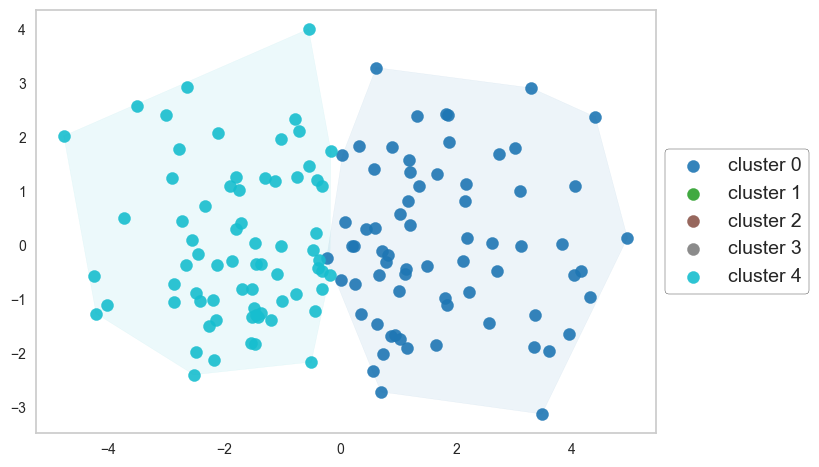

In [47]:
visualize2DClusterPoints(dataset_model, fcm_highest_label, n_clusters_selected, cluster_colors)

legend = plt.legend(loc='center left', fontsize=14,
                    bbox_to_anchor=(1, 0.5), frameon=True)
legend.get_frame().set_edgecolor('black')

savefig('2D Visualization of Fuzzy C-Means Cluster Points')
plt.show()

In [48]:
visualize3DClusterPoints(dataset_model, fcm_highest_label, n_clusters_selected, 'Fuzzy C-Means', cluster_colors)

## K-Medoids

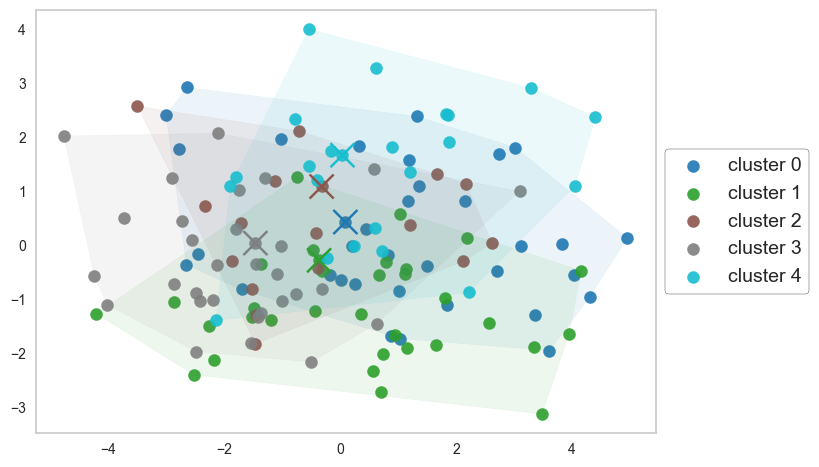

In [49]:
visualize2DClusterPoints(dataset_model, kmedoids_labels, n_clusters_selected, cluster_colors)

medoids_x, medoids_y = [], []
for medoid in kmedoids_models[n_clusters_selected].medoid_indices_:
#     print(f'medoid points: {medoid}')
#     print(f'x (PC-0) position: {df_pca.iloc[medoid, 0]}')
#     print(f'y (PC-1) position: {df_pca.iloc[medoid, 1]}')
    
    medoids_x.append(dataset_model.iloc[medoid, 0])
    medoids_y.append(dataset_model.iloc[medoid, 1])
    
#     print('='*50)

plt.scatter(medoids_x, medoids_y,
            marker='x', s=300, color=cluster_colors)

legend = plt.legend(loc='center left', fontsize=14,
                    bbox_to_anchor=(1, 0.5), frameon=True)
legend.get_frame().set_edgecolor('black')

savefig('2D Visualization of K-Medoids Cluster Points')
plt.show()

In [50]:
visualize3DClusterPoints(dataset_model, kmedoids_labels, n_clusters_selected, 'K-Medoids', cluster_colors)

## Gaussian Mixture Model

In [51]:
# visualize2DClusterPoints(dataset_model, gmm_labels, n_clusters_selected, cluster_colors)

# legend = plt.legend(loc='center left', fontsize=14,
#                     bbox_to_anchor=(1, 0.5), frameon=True)
# legend.get_frame().set_edgecolor('black')

# savefig('2D Visualization of Gaussian Mixture Model Cluster Points')
# plt.show()

In [52]:
# visualize3DClusterPoints(dataset_model, gmm_labels, n_clusters_selected, 'Gaussian Mixture Model', cluster_colors)

## K-Prototype

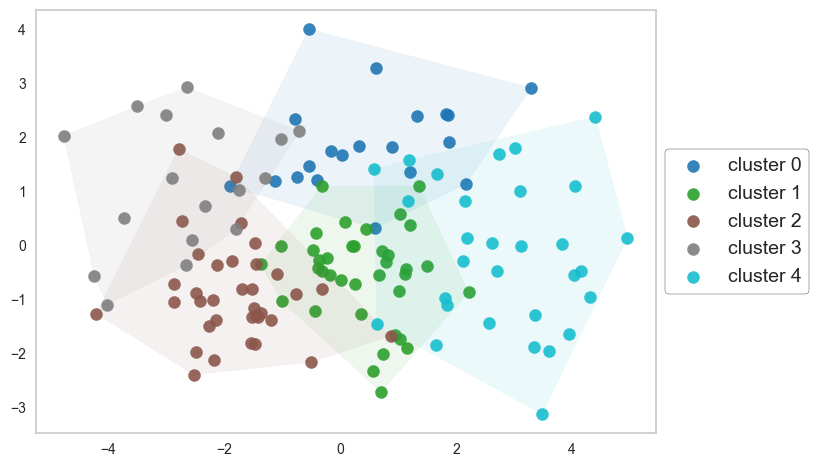

In [53]:
visualize2DClusterPoints(dataset_model, kprototype_labels, n_clusters_selected, cluster_colors)

legend = plt.legend(loc='center left', fontsize=14,
                    bbox_to_anchor=(1, 0.5), frameon=True)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set

savefig('2D Visualization of K-Prototype Cluster Points')
plt.show()

In [54]:
visualize3DClusterPoints(dataset_model, kprototype_labels, n_clusters_selected, 'K-Prototype', cluster_colors)

# Cluster Analysis

In [55]:
df_clean_data = pd.read_csv('./data/dataset_train_clean_data_only.csv')
df_clean_data

tahun_lahir   ipk  ips_semester_genap_2021/2022   
0              2  3.01                        2.9500  \
1              2  3.25                        3.1900   
2              3  3.29                        3.3300   
3              3  3.33                        3.5600   
4              3  3.32                        3.4100   
..           ...   ...                           ...   
134            2  3.34                        3.8700   
135            4  2.64                        2.7125   
136            2  2.57                        2.7125   
137            4  3.08                        3.1000   
138            4  3.32                        3.4100   

     ips_semester_ganjil_2022/2023  nilai_matkul_matematika_1   
0                           3.1000                          3  \
1                           3.3100                          3   
2                           3.0800                          6   
3                           3.4600                          3   
4                           3.3400                          1   
..                             ...                        ...   
134                         3.8100                          0   
135                         2.7700                          1   
136                         2.5125                          0   
137                         2.9900                          1   
138                         3.3400                          6   

     nilai_matkul_bahasa_inggris_1  total_sks_semester   
0                                6                22.0  \
1                                4                22.0   
2                                6                22.0   
3                                7                22.0   
4                                3                22.0   
..                             ...                 ...   
134                              4                19.5   
135                              6                20.0   
136                              3                22.0   
137                              5                22.0   
138                              7                22.0   

     total_matkul_mengulang  memiliki_beasiswa  nilai_matematika_sma_kelas_12   
0                       1.0                  0                          78.75  \
1                       0.0                  0                          89.00   
2                       0.0                  0                          89.00   
3                       1.0                  0                          82.00   
4                       0.0                  0                          89.00   
..                      ...                ...                            ...   
134                     0.0                  0                          89.00   
135                     1.0                  0                          81.00   
136                     1.0                  0                          89.00   
137                     0.0                  0                          91.00   
138                     0.0                  0                          89.00   

     ...  jenis_tempat_tinggal_keluarga_bersama anggota keluarga besar   
0    ...                                                0.0             \
1    ...                                                1.0              
2    ...                                                0.0              
3    ...                                                0.0              
4    ...                                                0.0              
..   ...                                                ...              
134  ...                                                0.0              
135  ...                                                0.0              
136  ...                                                0.0              
137  ...                                                0.0              
138  ...                                                0.0        

## Feature Importance

In [56]:
model_clusters = kprototype_labels[n_clusters_selected]
total_selected_feature = 20
dataset_feature_importance = dataset_model_normal
# dataset_feature_importance = df_clean_data

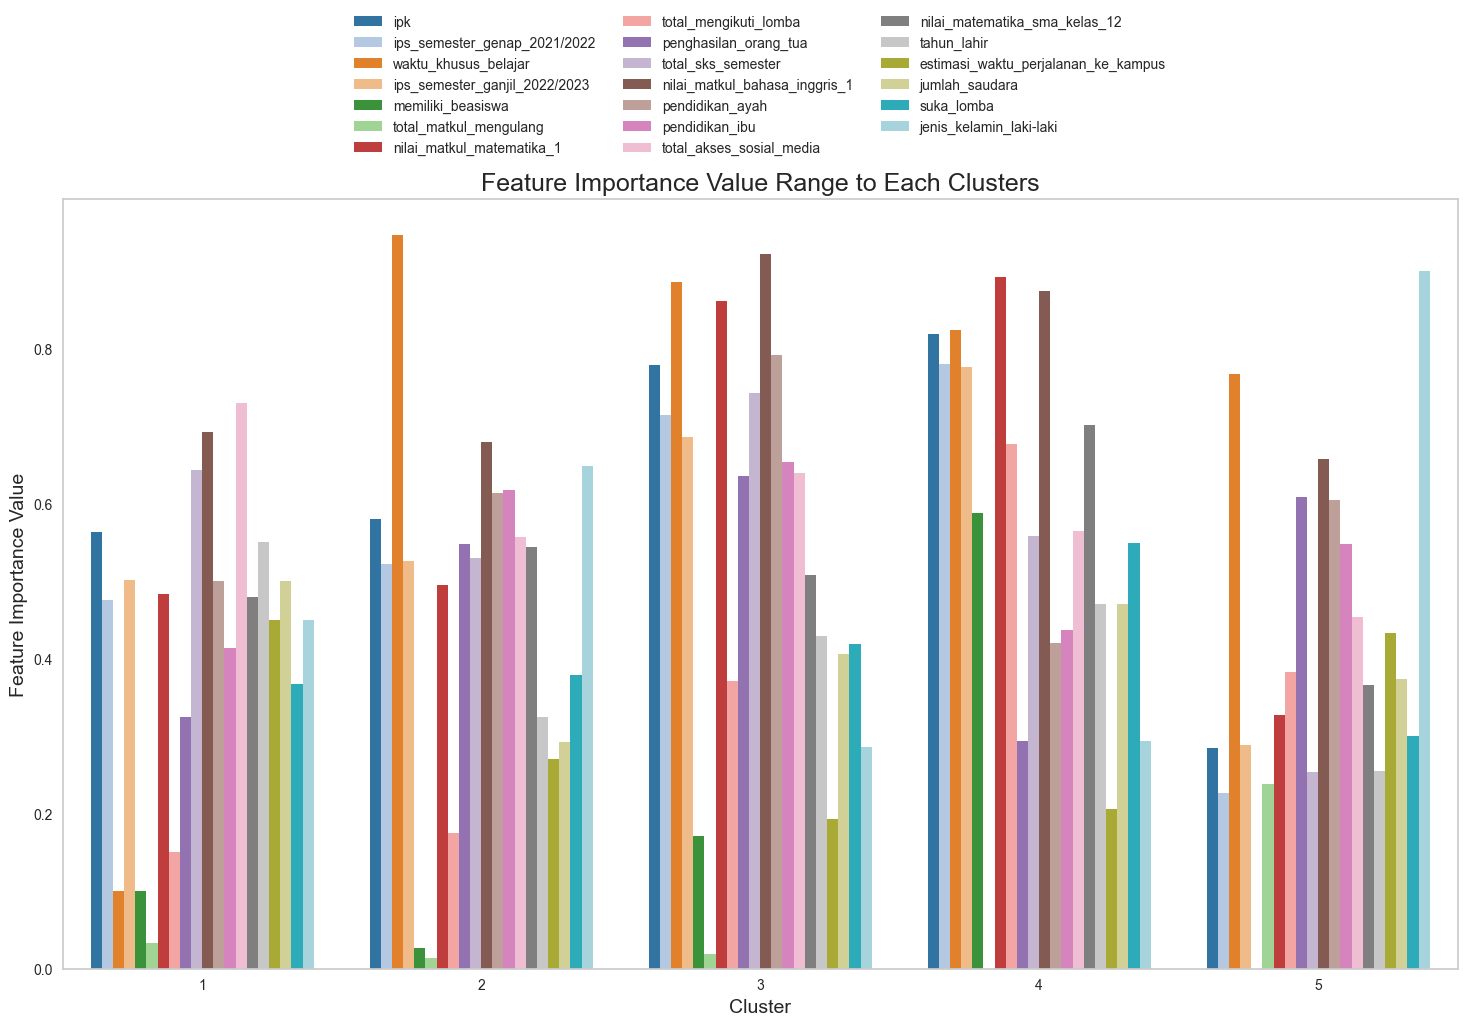

In [57]:
df_clustered = dataset_feature_importance.copy()
df_clustered['cluster'] = kprototype_labels[n_clusters_selected]

df_cluster_data_means = df_clustered.groupby('cluster').mean()
df_cluster_data_means
list_feature_importance = []

feature_variance = pd.DataFrame(columns=['feature', 'variance'])
for column in df_cluster_data_means.columns:
    feature_variance.loc[len(feature_variance), :] = [column, np.var(df_cluster_data_means[column])]

best_contribution_feature = list(feature_variance.sort_values('variance', ascending=False).head(total_selected_feature)['feature'])    
tidy = df_clean_data[best_contribution_feature].copy()
tidy = pd.DataFrame(MinMaxScaler().fit_transform(tidy), columns=tidy.columns)
tidy['cluster'] = df_clustered['cluster']
tidy = tidy.melt(id_vars='cluster')

fig, ax = plt.subplots(figsize=[18, 10])

sns.barplot(data=tidy, x='cluster', y='value', hue='variable',
            errorbar=None, palette='tab20', ax=ax)

ax.set_title('Feature Importance Value Range to Each Clusters', fontsize=18)
ax.set_xlabel('Cluster', fontsize=14)
ax.set_ylabel('Feature Importance Value', fontsize=14)
ax.set_xticklabels(np.arange(1, n_clusters_selected+1, 1))

ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.04),
          ncol=3, fancybox=True, shadow=True)

savefig('Cluster Feature Importance')
plt.show()

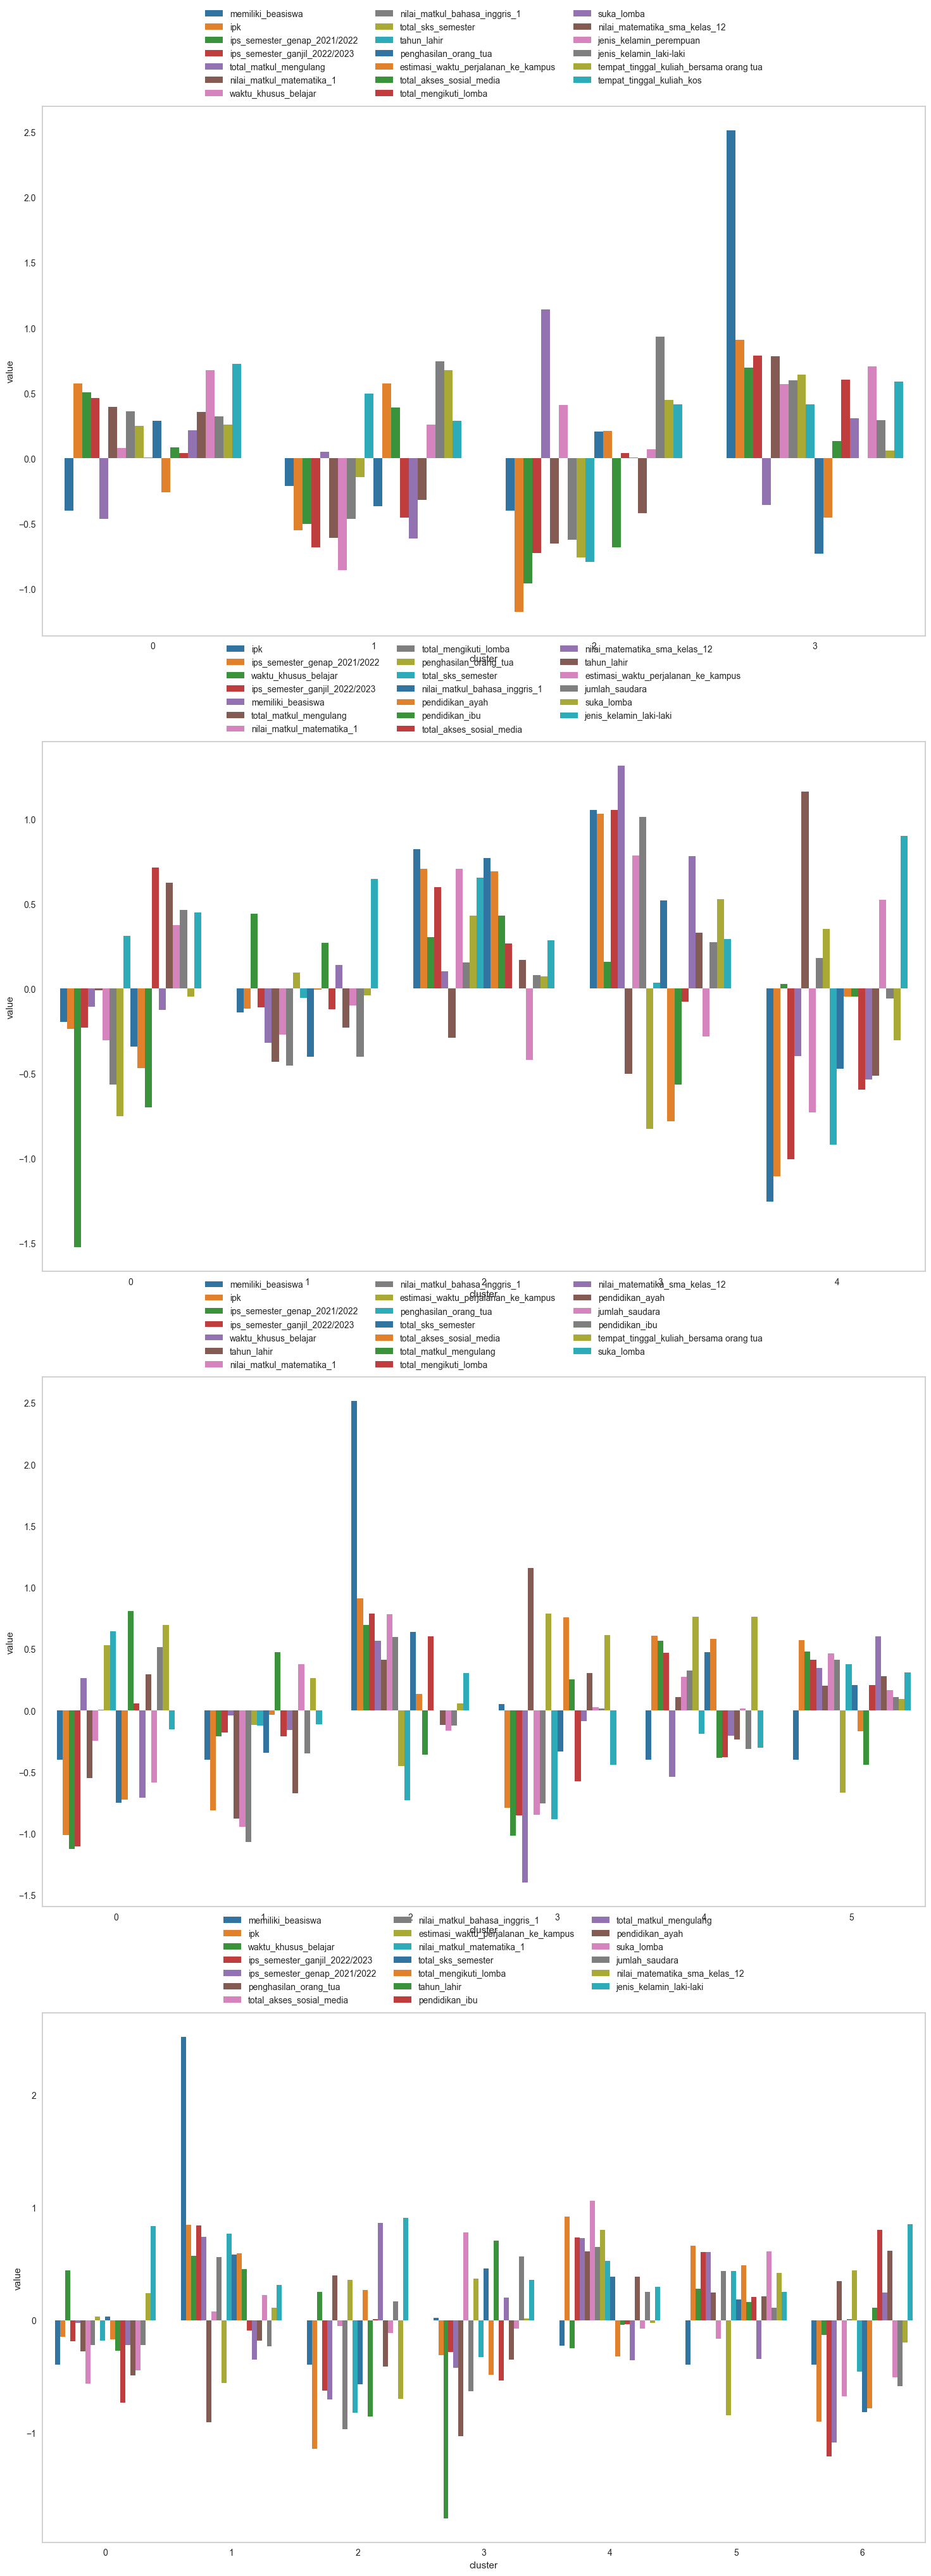

In [58]:
fig, axs = plt.subplots(len(kprototype_labels.keys()), 1, figsize=[18, 50])

for labels, ax in zip(kprototype_labels.values(), axs):
    df_clustered = dataset_model_normal.copy()
    df_clustered['cluster'] = labels
    
    df_cluster_data_means = df_clustered.groupby('cluster').mean()
    list_feature_importance = []

    feature_variance = pd.DataFrame(columns=['feature', 'variance'])
    for column in df_cluster_data_means.columns:
        feature_variance.loc[len(feature_variance), :] = [column, np.var(df_cluster_data_means[column])]
        
    best_contribution_feature = list(feature_variance.sort_values('variance', ascending=False).head(total_selected_feature)['feature'])    
    tidy = df_clustered[best_contribution_feature + ['cluster']].melt(id_vars='cluster')    

    sns.barplot(data=tidy, x='cluster', y='value', hue='variable',
                errorbar=None, palette='tab10', ax=ax)

    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1),
              ncol=3, fancybox=True, shadow=True)   
    
#     print('='*50)
    
savefig('Cluster Feature Importance All Total Cluster')
plt.show()

## Feature Importance

In [59]:
model = kprototype_models[n_clusters_selected]
cluster_labels = kprototype_labels[n_clusters_selected]

In [60]:
df_clustered = dataset_model_normal.copy()
df_clustered['cluster'] = cluster_labels

In [61]:
feature_columns = df_clustered.drop(columns='cluster').columns

In [62]:
clusters_feature_importances = {}

for cluster_label in range(n_clusters_selected):
    mapper = {key: 1 if key == cluster_label else 0 for key in range(n_clusters_selected)}
    df_clustered[f'binary_cluster_{cluster_label+1}'] = df_clustered['cluster'].map(mapper)
    
    cluster_clf = RandomForestClassifier(random_state=42)
    cluster_clf.fit(df_clustered[feature_columns].values, df_clustered[f'binary_cluster_{cluster_label+1}'].values)
#     print(cluster_clf.feature_importances_.shape)
#     print(cluster_clf.feature_importances_)
    
    feature_importance = {key: value for key, value in zip(feature_columns, cluster_clf.feature_importances_)}    
    feature_importance = {key: feature_importance[key] for key in sorted(feature_importance, key=feature_importance.get, reverse=True)}
#     display(feature_importance)
    
    clusters_feature_importances[f'Cluster_{cluster_label+1}'] = feature_importance
    
#     print('='*50)

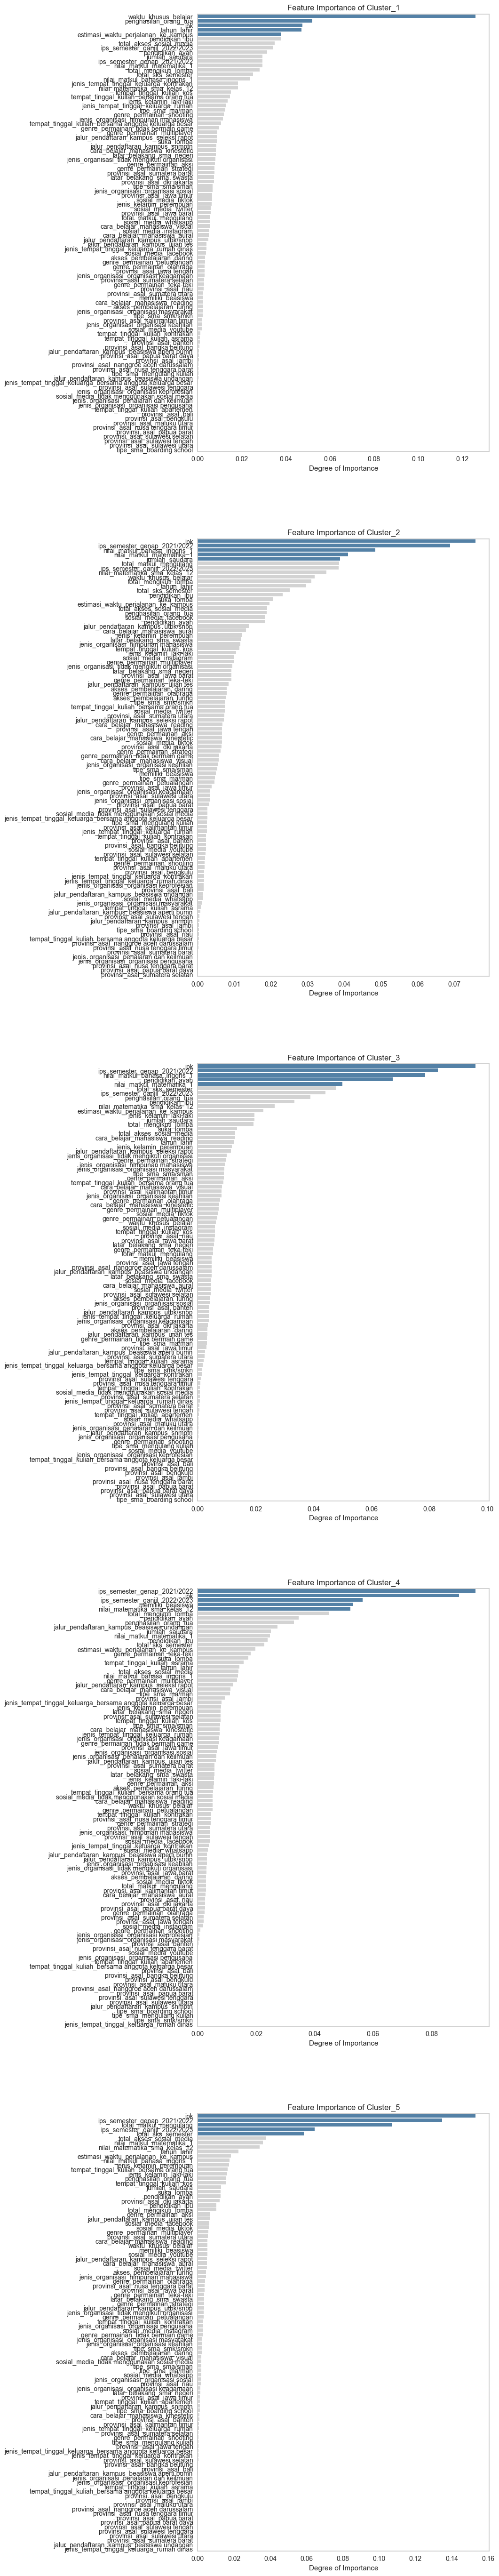

In [63]:
fig, axs = plt.subplots(n_clusters_selected, 1, figsize=[8, 14*n_clusters_selected])
colors = ['steelblue']*5 + ['lightgrey']*(cluster_clf.feature_importances_.shape[0] - 5)

for (ax, (cluster, feature_importance)) in zip(axs.flatten(), clusters_feature_importances.items()):
#     print(cluster)
#     display(feature_importance)
#     print(list(feature_importance.keys()))
#     print([feature_importance[key] for key in feature_importance.keys()])
    
    sns.barplot(x=[feature_importance[key] for key in feature_importance.keys()], y=list(feature_importance.keys()),
                palette=colors, ax=ax)
    
    ax.set_xlabel('Degree of Importance')
    ax.set_title(f'Feature Importance of {cluster}')
    
#     print('='*50)